In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math


In [243]:
train_data_raw =  pd.read_csv("Gasleak Data Sets/sensor_readings.csv")
train_data_raw.columns = ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

In [244]:
test_data_raw = pd.read_csv("Gasleak Data Sets/validation_files/sensor_readings.csv")
test_data_raw.columns =  ["temp","Time","Sensor 1", "Sensor 2", "Sensor 3", "Sensor 4", "Sensor 5", "Sensor 6", "Sensor 7", "Sensor 8", "Sensor 9", "Sensor 10", "Sensor 11", "Sensor 12", "Sensor 13", "Sensor 14", "Sensor 15", "Sensor 16", "Sensor 17", "Sensor 18", "Sensor 19", "Sensor 20", "Sensor 21", "Sensor 22", "Sensor 23", "Sensor 24"]

In [245]:
leak_data_raw = pd.concat([train_data_raw, test_data_raw], ignore_index=True)
leak_data = leak_data_raw.copy()
leak_data = leak_data.iloc[5000:7000]
leak_data = leak_data.drop(['temp'], axis=1)
leak_data['Time'] -= 1681776002
leak_data['Sum'] = leak_data.iloc[:,1:].sum(axis=1)
leak_data['Mean'] = leak_data.iloc[:,1:-1].mean(axis=1)

In [246]:
def MinMax(X, col):
    return (X - col.min()) / (col.max() - col.min())
def invMinMax(X_scaled, col):
    X = X_scaled * (col.max() - col.min()) + col.min()
    return X

In [247]:
scaler = MinMaxScaler()
leak_data['Normalized Sum'] = MinMax(leak_data['Sum'], leak_data['Sum'])
# scaler.fit_transform(leak_data['Sum'].values.reshape(-1,1))

leak_data['Normalized Mean'] = MinMax(leak_data['Mean'],leak_data['Mean'])
# scaler.fit_transform(leak_data['Mean'].values.reshape(-1,1))

leak_data['Normalized Sensor 1'] = MinMax(leak_data['Sensor 1'], leak_data['Sensor 1'])
# scaler.fit_transform(leak_data['Sensor 1'].values.reshape(-1,1))


# leak_data
# plt.plot()

In [248]:
def load_data(feature, look_back):
    data_raw = feature.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
feature =  leak_data[['Normalized Mean']] # have to put in two brackets because

x_train, y_train, x_test, y_test = load_data(feature, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1552, 59, 1)
y_train.shape =  (1552, 1)
x_test.shape =  (388, 59, 1)
y_test.shape =  (388, 1)


In [249]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [250]:
import model as m

input_dim = 1
hidden_dim = 16
num_layers = 2 
output_dim = 1

model = m.LSTM(input_dim=input_dim,hidden_dim=hidden_dim,num_layers=num_layers,output_dim=output_dim)

# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.L1Loss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())


LSTM(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)
10
torch.Size([64, 1])
torch.Size([64, 16])
torch.Size([64])
torch.Size([64])
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64])
torch.Size([64])
torch.Size([1, 16])
torch.Size([1])


In [251]:
import os

# Train model
num_epochs = 700
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = look_back - 1

# Set the checkpoint parameters
checkpoint_dir = "mean_checkpoints"  # Directory to save checkpoints
checkpoint_interval = 10  # Save a checkpoint every 10 epochs
start_epoch = 0  # Start from this epoch (useful for resuming training)

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Load the model state from a checkpoint (if available)
checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{start_epoch}.pth"
if start_epoch > 0 and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimiser.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}")

for t in range(start_epoch, num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)


    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MAE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

    # Save a checkpoint
    if (t + 1) % checkpoint_interval == 0:
        checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{t}.pth"
        torch.save({
            "epoch": t,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimiser.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved for epoch {t}")

Checkpoint saved for epoch 9
Epoch  10 MAE:  0.03458768129348755
Checkpoint saved for epoch 19
Epoch  20 MAE:  0.024105042219161987
Checkpoint saved for epoch 29
Epoch  30 MAE:  0.02347942814230919
Checkpoint saved for epoch 39
Epoch  40 MAE:  0.022794747725129128
Checkpoint saved for epoch 49
Epoch  50 MAE:  0.02224377915263176
Checkpoint saved for epoch 59
Epoch  60 MAE:  0.022030776366591454
Checkpoint saved for epoch 69
Epoch  70 MAE:  0.021764878183603287
Checkpoint saved for epoch 79
Epoch  80 MAE:  0.021361390128731728
Checkpoint saved for epoch 89
Epoch  90 MAE:  0.020670635625720024
Checkpoint saved for epoch 99
Epoch  100 MAE:  0.019130142405629158
Checkpoint saved for epoch 109
Epoch  110 MAE:  0.015995904803276062
Checkpoint saved for epoch 119
Epoch  120 MAE:  0.02804671600461006
Checkpoint saved for epoch 129
Epoch  130 MAE:  0.023203879594802856
Checkpoint saved for epoch 139
Epoch  140 MAE:  0.020157845690846443
Checkpoint saved for epoch 149
Epoch  150 MAE:  0.01777699

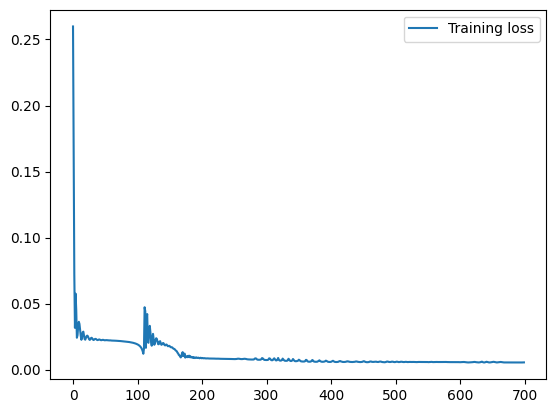

In [252]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [253]:
np.mean((y_train_pred.detach().numpy()-y_train.detach().numpy()) ** 2)

0.0017298644

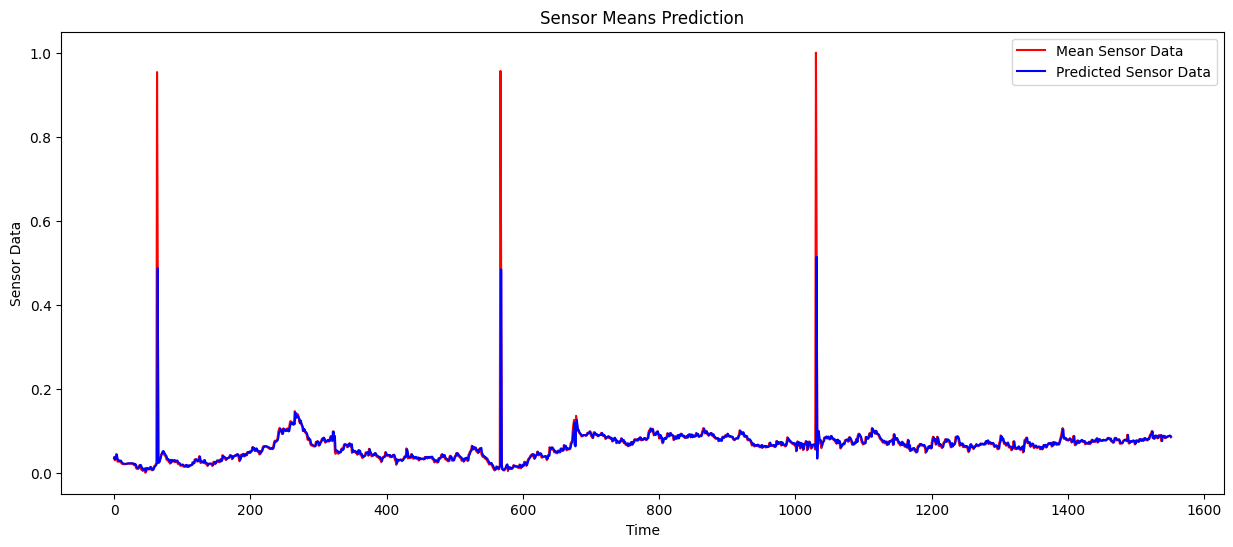

In [254]:
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot( y_train.detach().numpy(), color = 'red', label = 'Mean Sensor Data')
axes.plot( y_train_pred.detach().numpy(), color = 'blue', label = 'Predicted Sensor Data')
plt.title('Sensor Means Test')
plt.xlabel('Time')
plt.ylabel('Sensor Data')
plt.legend()
plt.show()

In [255]:
# %%
# make predictions
y_test_pred = model(x_test)

# # Implement transform
# # invert predictions
y_train_pred = (y_train_pred.detach().numpy())
y_train = (y_train.detach().numpy())
y_test_pred = (y_test_pred.detach().numpy())
y_test = (y_test.detach().numpy())


# invert predictions
y_train_pred = invMinMax(y_train_pred, leak_data['Mean'])
y_train = invMinMax(y_train, leak_data['Mean'])
y_test_pred = invMinMax(y_test_pred, leak_data['Mean'])
y_test = invMinMax(y_test, leak_data['Mean'])


y_test_pred = y_test_pred
print(type(y_train))



# calculate  mean absolute error
print(y_train[:,0], y_train_pred[:,0])
trainScore = (mean_absolute_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f MAE' % (trainScore))
testScore =(mean_absolute_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAE' % (testScore))


<class 'numpy.ndarray'>
[1003.7442   999.08655 1002.0955  ... 1039.4166  1038.2291  1036.5903 ] [1001.98846 1004.1425  1000.138   ... 1038.8314  1039.5099  1038.2699 ]
Train Score: 3.80 MAE
Test Score: 2.33 MAE


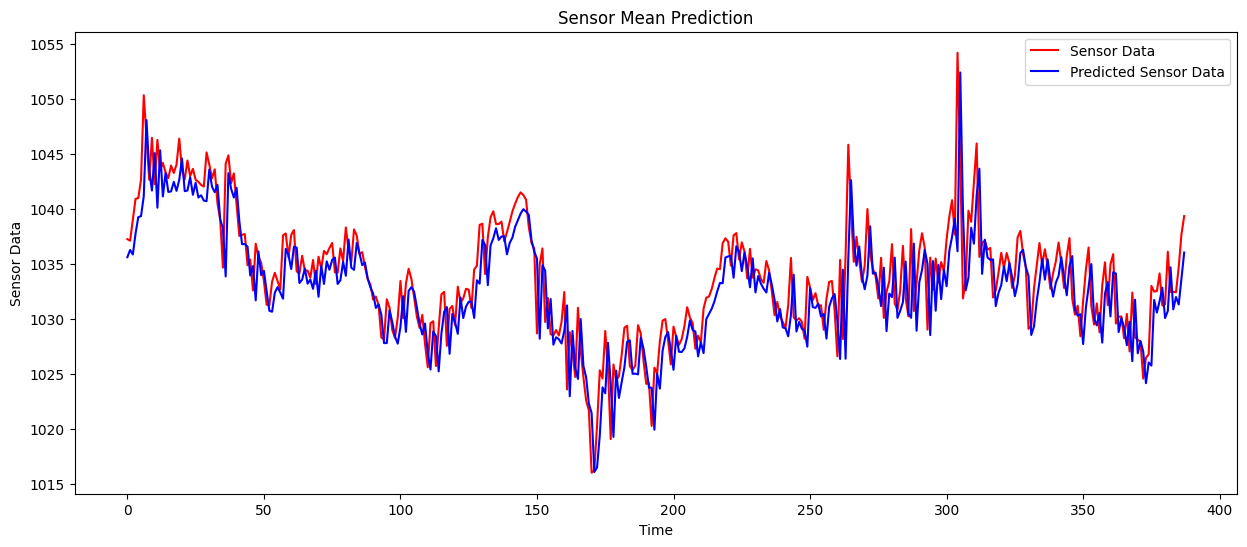

In [257]:
figure, axes = plt.subplots(figsize=(15, 6))

axes.plot( y_test, color = 'red', label = 'Sensor Data')
axes.plot( y_test_pred, color = 'blue', label = 'Predicted Sensor Data')
plt.title('Sensor Mean Prediction')
plt.xlabel('Time')
plt.ylabel('Sensor Data')
plt.legend()
plt.show()